In [17]:
import json
import pandas as pd    

dreamprm_meta = "../../DreamPRM/data/meta.json"
dreamprm_train = "../../DreamPRM/data/train.json"
MATH_path = "../MATH"

import os
MATH = {'train':{}, 'test':{}}
for i in MATH:
    path = os.path.join(MATH_path, i)
    for j in os.listdir(path):
        MATH[i][j] = [os.path.join(path, j, k) for k in os.listdir(os.path.join(path, j)) if k.endswith('.json')]
        

prm800k_path = "../prm800k/prm800k/data"
prm_split_path = {"test": "../prm800k/prm800k/math_splits/test.jsonl", 
                 "train": "../prm800k/prm800k/math_splits/train.jsonl"}
prm800k  = {}

for phase in range(1,3):
    prm800k[f"phase{phase}"] = {}
    for type in ['train', 'test']:
        prm800k[f"phase{phase}"][type] = f"{prm800k_path}/phase{phase}_{type}.jsonl"
        


In [18]:
ds = prm800k["phase2"]
ds = pd.read_json(path_or_buf=ds["train"], lines=True)

In [19]:
ds['correctness'] = ds['label'].apply(lambda x: x["finish_reason"])

In [20]:
ds["correctness"].unique()
## find each unique count
ds['correctness'].value_counts()

correctness
found_error    82003
solution       11665
give_up         3839
bad_problem      275
Name: count, dtype: int64

In [21]:
ds['label'].iloc[0]['steps'][0]['completions'][0]['rating']

1

In [ ]:
from datasets import  Dataset, concatenate_datasets, DatasetDict
import pandas as pd
from tqdm import tqdm


splits = ["train", "test"]


def augment(row):
    new_completions = []
    new_labels = []
    for t, l in zip(row["trajectories"], row["trajectories_labels"]):
        new_completions.append(row["completions"] + [t])
        new_labels.append(row["labels"] + [l])
    row["new_completions"] = new_completions
    row["new_labels"] = new_labels
    return row



def unnest_dataset_lists(
    dataset: Dataset,
    list_columns: str | list[str],
) -> Dataset:
    """
    Unnest list columns in a datasets.Dataset where each row contains a list of lists.
    Each inner list becomes a new row, maintaining alignment across specified columns.
    
    Args:
        dataset: The input datasets.Dataset
        list_columns: Column name(s) containing lists to unnest
        
    Returns:
        A new datasets.Dataset with unnested rows
    """
    df = dataset.to_pandas()
    
    if isinstance(list_columns, str):
        list_columns = [list_columns]
    
    # Create rows for each completion/label pair
    rows = []
    
    for idx, row in df.iterrows():
        # Get Number of Steps for this row
        num_completions = len(row[list_columns[0]])
        
        # For each completion
        for completion_idx in range(num_completions):
            new_row = {}
            
            # Copy non-list columns
            for col in df.columns:
                if col not in list_columns:
                    new_row[col] = row[col]
            
            # Add index to keep the reference to the prompt
            new_row['index'] = idx
            
            # Add list columns
            for col in list_columns:
                new_row[col] = row[col][completion_idx]
            
            rows.append(new_row)
    
    # Create new dataframe
    result_df = pd.DataFrame(rows)
    
    # Convert back to datasets.Dataset
    return Dataset.from_pandas(result_df)

full_ds = DatasetDict()

for split in splits:
    print("Split:", split)
    datasets = []
    for i, ds in enumerate(prm800k):
        ds = prm800k[ds]
        ds = pd.read_json(path_or_buf=ds[split], lines=True)
        ds['correctness'] = ds['label'].apply(lambda x: x["finish_reason"])
        print("phase:", i + 1)
        new_ds = []
        for row in tqdm(ds.iterrows(), total=len(ds)):
            row = row[1]  # Get the row data
            solution = []
            trajectories = []
            trajectories_labels = []
            label = []
            new_row = {}
            new_row["prompt"] = row["question"]["problem"]

            for step in row["label"]["steps"]:
                completions = step["completions"]
                if not completions:
                    continue
                if step["chosen_completion"] is None:
                    # Haven't found any relevant point here, discard them for the moment
                    #continue
                    if len(completions) > 1:
                        trajectories = []
                        trajectories_labels = []
                        for c in completions:
                            trajectories.append(c["text"])
                            trajectories_labels.append(not (c["rating"] == -1))
                        # We can continue here assuming there shouldn't be any more trajectories after this point
                        continue

                else:
                    completion = completions[step["chosen_completion"]]
                    solution.append(completion["text"])
                    label.append(not (completion["rating"] == -1))
                    continue

            new_row["trajectories"] = trajectories
            new_row["trajectories_labels"] = trajectories_labels
            new_row["completions"] = solution
            new_row["labels"] = label
            new_row['correctness'] = row['correctness']
            new_ds.append(new_row)

        new_ds = Dataset.from_list(new_ds)

        # Augment the dataset by adding the trajectories as completions
        ds_updated = new_ds.map(augment, num_proc=8)

        # Similar to a pd.DataFrame.explode, get a row per each nested list in the dataset,
        # so that we have all the possible alternative completions in separate rows
        print("Start unnesting...")
        updated = unnest_dataset_lists(
            ds_updated.select_columns(
                ["prompt", "new_completions", "new_labels", "correctness"]
            ),
            ["new_completions", "new_labels"]
        ).rename_columns(
            {"new_completions": "completions", "new_labels": "labels"}
        ).select_columns(["prompt", "completions", "labels", "index", "correctness"])  # Sort the column names

        datasets.append(updated)
    
    full_ds[split] = concatenate_datasets(datasets)

Split: train
phase: 1


100%|██████████| 949/949 [00:00<00:00, 14964.00it/s]


Map (num_proc=8):   0%|          | 0/949 [00:00<?, ? examples/s]

Start unnesting...
phase: 2


100%|██████████| 97782/97782 [00:05<00:00, 17410.19it/s]


Map (num_proc=8):   0%|          | 0/97782 [00:00<?, ? examples/s]

Start unnesting...
Split: test
phase: 1


100%|██████████| 106/106 [00:01<00:00, 55.88it/s]


Map (num_proc=8):   0%|          | 0/106 [00:00<?, ? examples/s]

Start unnesting...
phase: 2


100%|██████████| 2762/2762 [00:00<00:00, 19535.43it/s]


Map (num_proc=8):   0%|          | 0/2762 [00:00<?, ? examples/s]

Start unnesting...


In [23]:
df = full_ds['test'].to_pandas()
df[:10]

,prompt,completions,labels,index,correctness
0,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,solution
1,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,solution
2,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,solution
3,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,solution
4,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,solution
5,"Steve says to Jon, ""I am thinking of a polynom...","[Hey, you know Vieta's formulas, right?, Ok, s...","[True, True, True, True, True, True, True, Tru...",1,give_up
6,"Steve says to Jon, ""I am thinking of a polynom...","[Hey, you know Vieta's formulas, right?, Ok, s...","[True, True, True, True, True, True, True, Tru...",1,give_up
7,"Steve says to Jon, ""I am thinking of a polynom...","[Hey, you know Vieta's formulas, right?, Ok, s...","[True, True, True, True, True, True, True, Tru...",1,give_up
8,"Steve says to Jon, ""I am thinking of a polynom...","[Hey, you know Vieta's formulas, right?, Ok, s...","[True, True, True, True, True, True, True, Tru...",1,give_up
9,"Steve says to Jon, ""I am thinking of a polynom...","[Hey, you know Vieta's formulas, right?, Ok, s...","[True, True, True, True, True, True, True, Tru...",1,give_up


In [24]:
exhaustive=False

from datasets import Dataset
dataset = DatasetDict()
for split_type in ['test', 'train']:
    df = full_ds[split_type].to_pandas()
    train_split = pd.read_json(path_or_buf=prm_split_path[split_type], lines=True)
    df = df.merge(train_split, left_on='prompt', right_on='problem', how='inner')
    df = df.drop(columns=['solution', 'problem'])
    
    if exhaustive:
        rows = []
        for idx, row in tqdm(df.iterrows(), total=len(df)):
            for i in range(len(row["completions"])):
                new_row = {}
                new_row["prompt"] = row["prompt"]
                new_row["answer"] = row["answer"]
                new_row["subject"] = row["subject"]
                new_row["level"] = row["level"]
                new_row["completions"] = row["completions"][:i+1]
                new_row["labels"] = row["labels"][:i+1]
                new_row["index"] = row["index"]
                rows.append(new_row)
    
        df = pd.DataFrame(rows)
    
    
    
    df['completions_str'] = df['completions'].apply(lambda x: str(x))
    df['labels_str'] = df['labels'].apply(lambda x: str(x))
    df['prompt_str'] = df['prompt'].astype(str)
    df['unique_id'] = df['completions_str'] + df['prompt_str'] + df['labels_str']
    print(f"Total unique completions in train set: {len(df['unique_id'].unique())} out of {len(df)} total completions.")

    ## only keep unique rows
    df = df.drop_duplicates(subset=['unique_id'])
    df = df.drop(columns=['completions_str', 'labels_str', 'prompt_str', 'unique_id'])

    print("Length of dataset after removing duplicates:", len(df))
    dataset[split_type] = Dataset.from_pandas(df)

Total unique completions in train set: 9956 out of 10246 total completions.
Length of dataset after removing duplicates: 9956
Total unique completions in train set: 327698 out of 377938 total completions.
Length of dataset after removing duplicates: 327698


In [29]:
new_dataset = {
}
from datasets import Dataset, DatasetDict
for split in dataset:
    df = dataset[split].to_pandas()
    df.drop(columns=['__index_level_0__'], inplace=True)
    df = df[df['correctness']!='give_up']
    df.loc[df['correctness'] == 'solution', 'correctness'] = 1
    df.loc[df['correctness'] == 'found_error', 'correctness'] = 0
    new_dataset[split] = Dataset.from_pandas(df)
    display(df)


,prompt,completions,labels,index,correctness,answer,subject,level
0,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2
1,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2
2,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2
3,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2
4,Three pencils and a jumbo eraser cost $\$1.24$...,[Let's call the price of a pencil p and the pr...,"[True, True, True, True, True, False]",0,1,29,Algebra,2
...,...,...,...,...,...,...,...,...
9951,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, False]",2710,0,"(2,4)",Geometry,2
9952,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, True]",2710,0,"(2,4)",Geometry,2
9953,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, False]",2710,0,"(2,4)",Geometry,2
9954,"The point $(0,0)$ is reflected over the vertic...",[I need to find the coordinates of the final p...,"[True, False]",2710,0,"(2,4)",Geometry,2


,prompt,completions,labels,index,correctness,answer,subject,level
0,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2
1,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2
2,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2
3,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2
4,How many positive two-digit integers leave a r...,[So if a number leaves a remainder of 2 when d...,"[True, True, True, True, True, True, True, Tru...",1,1,12,Number Theory,2
...,...,...,...,...,...,...,...,...
327693,Find the greatest common divisor of 12 and 20.,"[To find the greatest common divisor, we need ...",[False],97732,0,4,Prealgebra,2
327694,Find the greatest common divisor of 12 and 20.,[Let's write out the prime factorization of 12.],[True],97732,0,4,Prealgebra,2
327695,Find the greatest common divisor of 12 and 20.,[Let's write the prime factorization for each ...,[True],97732,0,4,Prealgebra,2
327696,Find the greatest common divisor of 12 and 20.,[Let's prime factorize 12. 12 is divisible by ...,[True],97732,0,4,Prealgebra,2


In [ ]:
new_dataset = DatasetDict(new_dataset)
new_dataset.save_to_disk("../PRM800k_cleaned")

new_dataset.push_to_hub("FrozenWolf/prm800k", token="")

Saving the dataset (0/1 shards):   0%|          | 0/9881 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/326767 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/327 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/683 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FrozenWolf/prm800k/commit/9548c90b4de1eb9694e4c488fccaf7f917953a6a', commit_message='Upload dataset', commit_description='', oid='9548c90b4de1eb9694e4c488fccaf7f917953a6a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/FrozenWolf/prm800k', endpoint='https://huggingface.co', repo_type='dataset', repo_id='FrozenWolf/prm800k'), pr_revision=None, pr_num=None)

In [ ]:
dataset = new_dataset
dataset['train'], dataset['test']

(Dataset({
     features: ['prompt', 'completions', 'labels', 'index', 'correctness', 'answer', 'subject', 'level', '__index_level_0__'],
     num_rows: 327698
 }),
 Dataset({
     features: ['prompt', 'completions', 'labels', 'index', 'correctness', 'answer', 'subject', 'level', '__index_level_0__'],
     num_rows: 9956
 }))

In [15]:
from datasets import load_dataset
dataset = load_dataset("FrozenWolf/prm800k")


In [4]:
dataset.save_to_disk("../PRM800k_cleaned")

Saving the dataset (0/1 shards):   0%|          | 0/9956 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/327698 [00:00<?, ? examples/s]

## GEMINI AS META DATA

In [38]:

path = "AIME_Dataset_1983_2024_with_gemini_responses.csv"

import pandas as pd
output = pd.read_csv(path)
output


,ID,Year,Problem Number,Question,Answer,Part,generated_completion,cleaned_generated_completion,correctness
0,1983-1,1983,1,"Let $x$ , $y$ and $z$ all exceed $1$ and let $...",60,NaN,Here is a step-by-step reasoning to solve the ...,Here is a step-by-step reasoning to solve the ...,True
1,1983-2,1983,2,"Let $f(x)=|x-p|+|x-15|+|x-p-15|$ , where $0 < ...",15,NaN,Here is a step-by-step reasoning to determine ...,Here is a step-by-step reasoning to determine ...,True
2,1983-3,1983,3,What is the product of the real roots of the e...,20,NaN,Here is a step-by-step reasoning to solve the ...,Here is a step-by-step reasoning to solve the ...,True
3,1983-4,1983,4,A machine-shop cutting tool has the shape of a...,26,NaN,Here is a step-by-step reasoning to solve the ...,Here is a step-by-step reasoning to solve the ...,True
4,1983-5,1983,5,Suppose that the sum of the squares of two com...,4,NaN,Let $x$ and $y$ be two complex numbers. We are...,Let $x$ and $y$ be two complex numbers. We are...,True
...,...,...,...,...,...,...,...,...,...
928,2024-II-11,2024,11,Find the number of triples of nonnegative inte...,601,II,Here is a step-by-step derivation to find the ...,Here is a step-by-step derivation to find the ...,True
929,2024-II-12,2024,12,"Let $O(0,0),A(\tfrac{1}{2},0),$ and $B(0,\tfra...",23,II,"Let the points be $O(0,0)$, $A(\frac{1}{2}, 0)...","Let the points be $O(0,0)$, $A(\frac{1}{2}, 0)...",True
930,2024-II-13,2024,13,Let $\omega\neq 1$ be a 13th root of unity. Fi...,321,II,Here is a step-by-step reasoning to find the r...,Here is a step-by-step reasoning to find the r...,True
931,2024-II-14,2024,14,Let $b \geq 2$ be an integer. Call a positive ...,211,II,Let $n$ be a $b$-eautiful integer. By definiti...,Let $n$ be a $b$-eautiful integer. By definiti...,True


In [40]:
# Question: 'prompt', cleaned_generated_completion: 'completions', correctness: 'labels', native 'index', correctness: 'correctness', Answer:'answer', 

output = output.rename(columns={
    'Question': 'prompt',
    'cleaned_generated_completion': 'completions',
    'index': 'index',
    'Answer': 'answer'
})

output['completions'] = output['completions'].apply(lambda x: x.split('\n\n'))
labels = []
#### ORM assumption:
for correctness, completions in zip(output['correctness'], output['completions']):
    labels.append([correctness]*len(completions))
    
output['labels'] = labels

output

,ID,Year,Problem Number,prompt,answer,Part,generated_completion,completions,correctness,labels
0,1983-1,1983,1,"Let $x$ , $y$ and $z$ all exceed $1$ and let $...",60,NaN,Here is a step-by-step reasoning to solve the ...,[Here is a step-by-step reasoning to solve the...,True,"[True, True, True, True, True, True, True, Tru..."
1,1983-2,1983,2,"Let $f(x)=|x-p|+|x-15|+|x-p-15|$ , where $0 < ...",15,NaN,Here is a step-by-step reasoning to determine ...,[Here is a step-by-step reasoning to determine...,True,"[True, True, True, True, True, True, True, Tru..."
2,1983-3,1983,3,What is the product of the real roots of the e...,20,NaN,Here is a step-by-step reasoning to solve the ...,[Here is a step-by-step reasoning to solve the...,True,"[True, True, True, True, True, True, True, Tru..."
3,1983-4,1983,4,A machine-shop cutting tool has the shape of a...,26,NaN,Here is a step-by-step reasoning to solve the ...,[Here is a step-by-step reasoning to solve the...,True,"[True, True, True, True, True, True, True, Tru..."
4,1983-5,1983,5,Suppose that the sum of the squares of two com...,4,NaN,Let $x$ and $y$ be two complex numbers. We are...,[Let $x$ and $y$ be two complex numbers. We ar...,True,"[True, True, True, True, True, True, True, Tru..."
...,...,...,...,...,...,...,...,...,...,...
928,2024-II-11,2024,11,Find the number of triples of nonnegative inte...,601,II,Here is a step-by-step derivation to find the ...,[Here is a step-by-step derivation to find the...,True,"[True, True, True, True, True, True, True, Tru..."
929,2024-II-12,2024,12,"Let $O(0,0),A(\tfrac{1}{2},0),$ and $B(0,\tfra...",23,II,"Let the points be $O(0,0)$, $A(\frac{1}{2}, 0)...","[Let the points be $O(0,0)$, $A(\frac{1}{2}, 0...",True,"[True, True, True, True, True, True, True, Tru..."
930,2024-II-13,2024,13,Let $\omega\neq 1$ be a 13th root of unity. Fi...,321,II,Here is a step-by-step reasoning to find the r...,[Here is a step-by-step reasoning to find the ...,True,"[True, True, True, True, True, True, True, Tru..."
931,2024-II-14,2024,14,Let $b \geq 2$ be an integer. Call a positive ...,211,II,Let $n$ be a $b$-eautiful integer. By definiti...,[Let $n$ be a $b$-eautiful integer. By definit...,True,"[True, True, True, True, True, True, True, Tru..."


In [42]:
output['index'] = output.index
output

,ID,Year,Problem Number,prompt,answer,Part,generated_completion,completions,correctness,labels,index
0,1983-1,1983,1,"Let $x$ , $y$ and $z$ all exceed $1$ and let $...",60,NaN,Here is a step-by-step reasoning to solve the ...,[Here is a step-by-step reasoning to solve the...,True,"[True, True, True, True, True, True, True, Tru...",0
1,1983-2,1983,2,"Let $f(x)=|x-p|+|x-15|+|x-p-15|$ , where $0 < ...",15,NaN,Here is a step-by-step reasoning to determine ...,[Here is a step-by-step reasoning to determine...,True,"[True, True, True, True, True, True, True, Tru...",1
2,1983-3,1983,3,What is the product of the real roots of the e...,20,NaN,Here is a step-by-step reasoning to solve the ...,[Here is a step-by-step reasoning to solve the...,True,"[True, True, True, True, True, True, True, Tru...",2
3,1983-4,1983,4,A machine-shop cutting tool has the shape of a...,26,NaN,Here is a step-by-step reasoning to solve the ...,[Here is a step-by-step reasoning to solve the...,True,"[True, True, True, True, True, True, True, Tru...",3
4,1983-5,1983,5,Suppose that the sum of the squares of two com...,4,NaN,Let $x$ and $y$ be two complex numbers. We are...,[Let $x$ and $y$ be two complex numbers. We ar...,True,"[True, True, True, True, True, True, True, Tru...",4
...,...,...,...,...,...,...,...,...,...,...,...
928,2024-II-11,2024,11,Find the number of triples of nonnegative inte...,601,II,Here is a step-by-step derivation to find the ...,[Here is a step-by-step derivation to find the...,True,"[True, True, True, True, True, True, True, Tru...",928
929,2024-II-12,2024,12,"Let $O(0,0),A(\tfrac{1}{2},0),$ and $B(0,\tfra...",23,II,"Let the points be $O(0,0)$, $A(\frac{1}{2}, 0)...","[Let the points be $O(0,0)$, $A(\frac{1}{2}, 0...",True,"[True, True, True, True, True, True, True, Tru...",929
930,2024-II-13,2024,13,Let $\omega\neq 1$ be a 13th root of unity. Fi...,321,II,Here is a step-by-step reasoning to find the r...,[Here is a step-by-step reasoning to find the ...,True,"[True, True, True, True, True, True, True, Tru...",930
931,2024-II-14,2024,14,Let $b \geq 2$ be an integer. Call a positive ...,211,II,Let $n$ be a $b$-eautiful integer. By definiti...,[Let $n$ be a $b$-eautiful integer. By definit...,True,"[True, True, True, True, True, True, True, Tru...",931


In [44]:
from datasets import Dataset
dataset = Dataset.from_pandas(output)
dataset

Dataset({
    features: ['ID', 'Year', 'Problem Number', 'prompt', 'answer', 'Part', 'generated_completion', 'completions', 'correctness', 'labels', 'index'],
    num_rows: 933
})

In [ ]:
dataset.save_to_disk('../Gemini-AIME-Meta')
dataset.push_to_hub("FrozenWolf/Gemini-AIME-Meta", token="")

Saving the dataset (0/1 shards):   0%|          | 0/933 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FrozenWolf/Gemini-AIME-Meta/commit/03dbdb9942a45548ba18b286bf1b5466303d8360', commit_message='Upload dataset', commit_description='', oid='03dbdb9942a45548ba18b286bf1b5466303d8360', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/FrozenWolf/Gemini-AIME-Meta', endpoint='https://huggingface.co', repo_type='dataset', repo_id='FrozenWolf/Gemini-AIME-Meta'), pr_revision=None, pr_num=None)

In [248]:
dataset

DatasetDict({
    test: Dataset({
        features: ['prompt', 'completions', 'labels', 'index', 'answer', 'subject', 'level'],
        num_rows: 9956
    })
    train: Dataset({
        features: ['prompt', 'completions', 'labels', 'index', 'answer', 'subject', 'level'],
        num_rows: 327797
    })
})

### DATALOADER TESTING

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import re
from datasets import load_dataset, Dataset
import pandas as pd
import os
import numpy as np
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B-Instruct")
tokenizer.add_tokens(["<PRM_STEP_SCORE>"])
data = load_dataset("FrozenWolf/prm800k")

subjects_map = {'Algebra':0,
 'Counting & Probability':1,
 'Geometry':2,
 'Intermediate Algebra':3,
 'Number Theory':4,
 'Prealgebra':5,
 'Precalculus':6,
 'Others':7}


def chat_template( question, steps):
        steps = ' <PRM_STEP_SCORE> \n'.join(steps)
        
        prompt = f'''Question:
{question}
Answer:
{steps} <PRM_STEP_SCORE>'''
        
        return prompt
    
def chat_template_no_special( question, steps):
        steps = '\n'.join(steps)
        
        prompt = f'''Question:
{question}
Answer:
{steps} <PRM_STEP_SCORE>'''
        
        return prompt





class QwenMathDataset(Dataset):
    '''
    This one generates a single trajectory per iteration and ALL steps accuracy like:
    [A, B, C] -> [T, F, T]
    '''
    def __init__(self, data, tokenizer, special_tokens=True, inference=False):
        self.dataset = data
        self.tokenizer = tokenizer
        self.special_tokens = special_tokens
        self.inference = inference
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        print("index", idx, type(idx))
        prompt = self.dataset[idx]['prompt']
        completions = self.dataset[idx]['completions']
        raw_labels = self.dataset[idx]['labels']
        print("raw_labels", raw_labels, idx, subjects_map)
        dset = subjects_map[self.dataset[idx]['subject']]

        if self.special_tokens:
            text = chat_template(prompt, completions)
        else:
            text = chat_template_no_special(prompt, completions)    
        

        model_inputs = self.tokenizer([text], return_tensors="pt")
        labels = torch.ones_like(model_inputs['input_ids']).float()

        if self.special_tokens:
            labels[(model_inputs['input_ids']!=len(self.tokenizer)-1)] = -100
            labels[(model_inputs['input_ids']==len(self.tokenizer)-1)] = torch.tensor(raw_labels).float()
        else:
            labels *= -100
            labels[-1] = torch.tensor(raw_labels).float()[-1]

        model_inputs["dataset"] = dset
        model_inputs["labels"] = labels
        

        return [model_inputs['input_ids']], [model_inputs['attention_mask']], [labels], [dset]
    



qwen_ds = QwenMathDataset(data['train'], tokenizer, special_tokens=True)
next(iter(qwen_ds))

AttributeError: 'QwenMathDataset' object has no attribute '_indices'

In [1]:
from prm_data import *
## reload this dataset class
# import importlib
# importlib.reload(prm_data)

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForTokenClassification

model_name = "Qwen/Qwen2-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_tokens(['<PRM_STEP_SCORE>'])

    
(
    train_dataloader,
    meta_dataloader,
    test_dataloader,
) = build_dataloader(
    tokenizer=tokenizer,
    train_batch_size= 2,
    meta_batch_size= 1,
    token_based=True,
    meta_dataset="AIME",
)



batch = next(iter(meta_dataloader))
batch['index']

Qwen2TokenizerFast(name_or_path='Qwen/Qwen2-0.5B', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<PRM_STEP_SCORE>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
}
) 2 1 True AIME False
Loading aime_outputs/test2025-II/o4-mini/AIME_o4_mini_8_traj_25_II.jsonl with 15 samples
[0]
Loading aime_outputs/test2025-II/qwen-instruct-1.5B/test2025-II_

[509]

In [13]:
import pandas as pd
df = pd.read_json(path_or_buf="aime_outputs/test2025-I/o4-mini/AIME_o4_mini_8_traj_25_I.jsonl", lines=True)
df

,id,problem,generated_responses,generated_answers,gold_answer,is_correct,answers_correctness,majority_voting,majority_voting_is_correct,prompt
0,I-1,Find the sum of all integer bases $b > 9$ for ...,[We work in an integer base \(b>9\). In base ...,"[70, 70, 70, 70, 70, 70, 70, 70]",70,True,"[True, True, True, True, True, True, True, True]",70,True,Find the sum of all integer bases $b > 9$ for ...
1,I-2,"On $\triangle ABC$, points $A$, $D$, $E$, and ...",[**Solution.** \nWe begin by introducing conv...,"[588, 588, 588, 588, 588, 588, 588, 588]",588,True,"[True, True, True, True, True, True, True, True]",588,True,"On $\triangle ABC$, points $A$, $D$, $E$, and ..."
2,I-3,The 9 members of a baseball team went to an ic...,"[Solution.\n\nLabel the nine players as 1,2,…,...","[16, 16, 16, 16, 16, 16, 16, 16]",16,True,"[True, True, True, True, True, True, True, True]",16,True,The 9 members of a baseball team went to an ic...
3,I-4,"Find the number of ordered pairs $(x,y)$, wher...","[We wish to count integer solutions \((x,y)\in...","[117, 117, 117, 117, 117, 117, 117, 117]",117,True,"[True, True, True, True, True, True, True, True]",117,True,"Find the number of ordered pairs $(x,y)$, wher..."
4,I-5,There are $8! = 40320$ eight-digit positive in...,"[We must count the 8‐digit permutations of 1,2...","[279, 279, 279, 279, 279, 279, 279, 279]",279,True,"[True, True, True, True, True, True, True, True]",279,True,There are $8! = 40320$ eight-digit positive in...
5,I-6,An isosceles trapezoid has an inscribed circle...,[Here is a complete solution.\n\n**Solution.**...,"[504, 504, 504, 504, 504, 504, 504, 504]",504,True,"[True, True, True, True, True, True, True, True]",504,True,An isosceles trapezoid has an inscribed circle...
6,I-7,"The twelve letters $A$, $B$, $C$, $D$, $E$, $F...",[First we label the twelve letters by their us...,"[821, 79, 821, 821, 821, 710, 821, 821]",821,True,"[True, False, True, True, True, False, True, T...",821,True,"The twelve letters $A$, $B$, $C$, $D$, $E$, $F..."
7,I-8,Let $k$ be a real number such that the system\...,[We identify complex numbers \(z=x+iy\) with p...,"[77, 77, 77, 77, 77, 77, 77, 77]",77,True,"[True, True, True, True, True, True, True, True]",77,True,Let $k$ be a real number such that the system\...
8,I-9,The parabola with equation $y = x^2 - 4$ is ro...,[We begin by parameterize the original parabol...,"[62, , 62, 62, 62, 62, 62, 62]",62,True,"[True, False, True, True, True, True, True, True]",62,True,The parabola with equation $y = x^2 - 4$ is ro...
9,I-10,The 27 cells of a $3 \times 9$ grid are filled...,"[We label the rows by 1,2,3, the columns by 1,...","[81, 81, 81, 81, 81, 81, 81, 119]",81,True,"[True, True, True, True, True, True, True, False]",81,True,The 27 cells of a $3 \times 9$ grid are filled...


In [18]:
for i in df['generated_responses'].iloc[1][1].split('\n\n'):
    print(i)
    print("==="*10)

**Solution.**  We begin by choosing convenient coordinates so that the computations become purely algebraic.  Let 
\[
A=(0,0),
\quad B=(28,0),
\]
so that \(AB=28=4+16+8\), and write
\[
C=(X,Y),
\]
with \(AC=91=13+52+26\) so
\[
X^2+Y^2=91^2=8281.
\]
On \(AB\) we have
\[
D\text{ at distance }4\text{ from }A\;\Longrightarrow\;D=(4,0),
\quad
E\text{ at distance }4+16=20\text{ from }A\;\Longrightarrow\;E=(20,0).
\]
On \(AC\), since \(AF=13\) and \(AC=91\), the point \(F\) is the \(\tfrac{13}{91}\)-point of \(AC\):
\[
F=\frac{13}{91}C=\Bigl(\tfrac{13}{91}X,\;\tfrac{13}{91}Y\Bigr).
\]
Similarly \(G\) lies so that \(AG=13+52=65\), hence
\[
G=\frac{65}{91}C=\Bigl(\tfrac{65}{91}X,\;\tfrac{65}{91}Y\Bigr).
\]
Next \(M\) is the reflection of \(D\) across \(F\), so
\[
M=2F-D
=\Bigl(2\cdot\tfrac{13}{91}X-4,\;2\cdot\tfrac{13}{91}Y-0\Bigr)
=\Bigl(\tfrac{26}{91}X-4,\;\tfrac{26}{91}Y\Bigr).
\]
And \(N\) is the reflection of \(G\) across \(E\), so
\[
N=2E-G
=\Bigl(2\cdot20-\tfrac{65}{91}X,\;0- \tfrac{65}{

In [3]:
batch['correctness']

[[True]]

In [2]:
batch['index']

[92, 92, 92, 92, 92]

In [20]:
model

QwenMathCondGen_RM(
  (base_model): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151647, 896)
      (layers): ModuleList(
        (0-23): 24 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear(in_features=896, out_features=896, bias=True)
            (k_proj): Linear(in_features=896, out_features=128, bias=True)
            (v_proj): Linear(in_features=896, out_features=128, bias=True)
            (o_proj): Linear(in_features=896, out_features=896, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
            (up_proj): Linear(in_features=896, out_features=4864, bias=False)
            (down_proj): Linear(in_features=4864, out_features=896, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        )
      )
 

In [19]:
from model import *
model = QwenMathCondGen_RM("cuda", "Qwen/Qwen2-0.5B")
model.to("cuda")
# model = QwenMathCondGen_RM("cuda", "Qwen/Qwen2-0.5B")

/home/frozenwolf/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/frozenwolf/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Model dtype: torch.bfloat16
Added 1 new tokens to the tokenizer and model. The token is <PRM_STEP_SCORE>.


QwenMathCondGen_RM(
  (base_model): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151647, 896)
      (layers): ModuleList(
        (0-23): 24 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear(in_features=896, out_features=896, bias=True)
            (k_proj): Linear(in_features=896, out_features=128, bias=True)
            (v_proj): Linear(in_features=896, out_features=128, bias=True)
            (o_proj): Linear(in_features=896, out_features=896, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
            (up_proj): Linear(in_features=896, out_features=4864, bias=False)
            (down_proj): Linear(in_features=4864, out_features=896, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        )
      )
 

In [2]:
batch = next(iter(test_dataloader['test2025-II']['aime_outputs/test2025-II/o4-mini']))
batch['label'].shape, batch['index']

(torch.Size([65, 838]),
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [20]:
test_dataloader['test2025-I']['aime_outputs/test2025-I/o4-mini'].dataset.dataset

Dataset({
    features: ['id', 'problem', 'completions', 'generated_answers', 'gold_answer', 'is_correct', 'answers_correctness', 'majority_voting', 'majority_voting_is_correct', 'prompt', 'index', 'labels', 'subject'],
    num_rows: 120
})

In [5]:
# meta_dataloader.dataset.dataset['correctness']

In [6]:
batch = next(iter(meta_dataloader))
batch['label'].shape

torch.Size([11, 2862])

In [9]:

device = "cuda"
labels = batch['label'].to(device) ## (B, T)
correctness = torch.tensor(batch['correctness'], dtype=torch.float).to(device) ## (B, )
score = model(batch['input_ids'].to(device),
                                     batch['attention_mask'].to(device))

In [10]:
score.shape, labels.shape, correctness.shape

(torch.Size([4]), torch.Size([4, 215]), torch.Size([1, 1]))

In [11]:
batch['index']

[6219, 6219, 6219, 6219]

In [12]:
criterion = nn.MSELoss(reduction='none')
criterion_meta = nn.MSELoss()
criterion_CE = nn.BCEWithLogitsLoss(reduction='none')


nproblems = set(batch['index']) # [0, 1, 2, B_Size-1]
# score -> (B * T*(T+1)/2) So [A_0_1, A_0_2,.. B_0_1, B_0_2,...] in cummulative order
score = torch.log(score / (1 - score))
outputs = []
for i in nproblems:
    mean_score = 0
    step = 0
    for j in range(len(score)):
        if batch['index'][j] == i:
            mean_score += score[j]
            step += 1
    mean_score /= step
    
    outputs.append(mean_score)
    
## outputs -> (B, )
## label -> ## (B * T*(T+1)/2)
outputs = torch.stack(outputs) # (B, )
outputs = torch.sigmoid(outputs)
loss = criterion_meta(outputs, correctness)

/home/frozenwolf/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [19]:
non_filler = (labels != -100).float()
index = torch.argmax(non_filler, dim=1)
labels = labels[torch.arange(labels.size(0)),index]  # (B, )
loss = criterion(score, labels)
        

In [25]:
nproblems = set(batch['index']) # [0, 1, 2, B_Size-1]
score = torch.log(score / (1 - score))
outputs = []
for i in nproblems:
    mean_score = 0
    step = 0
    for j in range(len(score)):
        if batch['index'][j] == i:
            mean_score += score[j]
            step += 1
    mean_score /= step
    outputs.append(mean_score)
outputs = torch.stack(outputs) # (B, )
outputs = torch.sigmoid(outputs)

ZeroDivisionError: division by zero

In [26]:
batch['index']

[7024, 7024, 8032, 8032, 7133, 7133, 7133, 7133, 7133]

In [9]:
outputs

tensor([0.9453, 0.9297, 0.9219], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<SigmoidBackward0>)

In [5]:
load_dataset("FrozenWolf/Gemini-AIME-Meta")['train']

Dataset({
    features: ['ID', 'Year', 'Problem Number', 'prompt', 'answer', 'Part', 'generated_completion', 'completions', 'correctness', 'labels', 'index'],
    num_rows: 933
})

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import re
from datasets import load_dataset, Dataset
import pandas as pd
import os
import numpy as np
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B-Instruct")
tokenizer.add_tokens(["<PRM_STEP_SCORE>"])
dataset = load_dataset("FrozenWolf/prm800k")


    
    
subjects_map = {'Algebra':0,
 'Counting & Probability':1,
 'Geometry':2,
 'Intermediate Algebra':3,
 'Number Theory':4,
 'Prealgebra':5,
 'Precalculus':6,
 'Others':7}

def chat_template( question, steps):
        steps = ' <PRM_STEP_SCORE> \n'.join(steps)
        
        prompt = f'''Question:
{question}
Answer:
{steps} <PRM_STEP_SCORE>'''
        
        return prompt
    
def chat_template_no_special( question, steps):
        steps = '\n'.join(steps)
        
        prompt = f'''Question:
{question}
Answer:
{steps} <PRM_STEP_SCORE>'''
        
        return prompt


class QwenMathDataset(Dataset):
    '''
    This one generates a single trajectory per iteration and ALL steps accuracy like:
    [A, B, C] -> [T, F, T]
    '''
    def __init__(self, data, tokenizer, special_tokens=True, inference=False):
        self.dataset = data
        self.tokenizer = tokenizer
        self.special_tokens = special_tokens
        self.inference = inference
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        print("index", idx, type(idx))
        prompt = self.dataset[idx]['prompt']
        completions = self.dataset[idx]['completions']
        raw_labels = self.dataset[idx]['labels']
        print("raw_labels", raw_labels, idx, subjects_map)
        dset = subjects_map[self.dataset[idx]['subject']]

        if self.special_tokens:
            text = chat_template(prompt, completions)
        else:
            text = chat_template_no_special(prompt, completions)    
        

        model_inputs = self.tokenizer([text], return_tensors="pt")
        labels = torch.ones_like(model_inputs['input_ids']).float()

        if self.special_tokens:
            labels[(model_inputs['input_ids']!=len(self.tokenizer)-1)] = -100
            labels[(model_inputs['input_ids']==len(self.tokenizer)-1)] = torch.tensor(raw_labels).float()
        else:
            labels *= -100
            labels[-1] = torch.tensor(raw_labels).float()[-1]

        model_inputs["dataset"] = dset
        model_inputs["labels"] = labels
        

        return [model_inputs['input_ids']], [model_inputs['attention_mask']], [labels], [dset]
    
    
ds = QwenMathDataset(dataset['train'], tokenizer, special_tokens=True, inference=False)
next(iter(ds))

AttributeError: 'QwenMathDataset' object has no attribute '_indices'

In [3]:
def collate_merge_minibatch(batch):
    if len(batch[0]) == 4:
        names = ["input_ids", "attention_mask", "labels", "index"]
    elif len(batch[0]) == 5:
        names = ["input_ids", "attention_mask", "labels", "dataset", "correctness"]
    else:
        raise ValueError("Batch items must contain 4 or 5 elements.")
    merged = {}
    for name_idx, item in enumerate(zip(*batch)):
        j = []
        for i in item:
            j+=i
        if isinstance(j[0], torch.Tensor):
            max_len = max([i.shape[-1] for i in j ])
        for i in range(len(j)):    
            if isinstance(j[i], torch.Tensor):
                if names[name_idx] == "input_ids":
                    j[i] = torch.cat((j[i], torch.ones(1, max_len - j[i].shape[-1])*tokenizer.pad_token_id), dim=-1)
                elif names[name_idx] == "attention_mask":
                    j[i] = torch.cat((j[i], torch.zeros(1, max_len - j[i].shape[-1])), dim=-1)
                elif names[name_idx] == "labels":
                    j[i] = torch.cat((j[i], torch.ones(1, max_len - j[i].shape[-1])*-100), dim=-1)
                elif names[name_idx] == "correctness":
                    j[i] = torch.tensor(j[i]).float()
        if isinstance(j[0], torch.Tensor):
            j = torch.cat(j, dim=0)
        merged[names[name_idx]] = j
    return merged

In [4]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=collate_merge_minibatch)

next(iter(train_dataloader))  

index 67031 <class 'int'>
raw_labels [True, True, True, True, True, True, True, True, True, True, False] 67031 {'Algebra': 0, 'Counting & Probability': 1, 'Geometry': 2, 'Intermediate Algebra': 3, 'Number Theory': 4, 'Prealgebra': 5, 'Precalculus': 6, 'Others': 7}
index 21090 <class 'int'>
raw_labels [True, True, True, True, True, True, True, True, False] 21090 {'Algebra': 0, 'Counting & Probability': 1, 'Geometry': 2, 'Intermediate Algebra': 3, 'Number Theory': 4, 'Prealgebra': 5, 'Precalculus': 6, 'Others': 7}
index 169948 <class 'int'>
raw_labels [True, True] 169948 {'Algebra': 0, 'Counting & Probability': 1, 'Geometry': 2, 'Intermediate Algebra': 3, 'Number Theory': 4, 'Prealgebra': 5, 'Precalculus': 6, 'Others': 7}
index 135737 <class 'int'>
raw_labels [True, True, True] 135737 {'Algebra': 0, 'Counting & Probability': 1, 'Geometry': 2, 'Intermediate Algebra': 3, 'Number Theory': 4, 'Prealgebra': 5, 'Precalculus': 6, 'Others': 7}


{'input_ids': tensor([[ 14582.,    510.,   4340.,  ...,  12947.,    220., 151665.],
         [ 14582.,    510.,  10048.,  ..., 151643., 151643., 151643.],
         [ 14582.,    510.,  10061.,  ..., 151643., 151643., 151643.],
         [ 14582.,    510.,  10061.,  ..., 151643., 151643., 151643.]]),
 'attention_mask': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'labels': tensor([[-100., -100., -100.,  ..., -100., -100.,    0.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]]),
 'index': [1, 1, 3, 6]}

In [57]:
train_dataloader.dataset.dataset[0]['subject']

'Number Theory'

In [11]:
neg = 0
pos = 0
neg_per_sent = 0
for label in dataset['train']['labels']:
    c = False
    for l in label:
        if l:
            pos += 1
        else:
            neg += 1
            if not c:
                neg_per_sent += 1
                c = True
            
print(f"Total positive labels in train set: {pos*100/(pos+neg)}, negative labels: {neg*100/(pos+neg)}")
print(f"Atleast 1 Neg labels per sentence: {neg_per_sent*100 / len(dataset['train'])}")

Total positive labels in train set: 89.96407002368821, negative labels: 10.035929976311786
Atleast 1 Neg labels per sentence: 60.82239922879099


In [49]:
from datasets import load_dataset

dataset = load_dataset("FrozenWolf/prm800k")

In [50]:
from tqdm import tqdm
lengths = []
for i in tqdm(dataset['train']['completions']):
    lengths.append(len(i))
    


100%|██████████| 326767/326767 [00:00<00:00, 3169460.13it/s]


{1: 31784, 2: 39447, 3: 39883, 4: 39296, 5: 33405, 6: 27842, 7: 24177, 8: 19609, 9: 14640, 10: 11711, 11: 8896, 12: 7143, 13: 5774, 14: 5133, 15: 3957, 16: 2885, 17: 2280, 18: 1785, 19: 1510, 20: 1056, 21: 787, 22: 709, 23: 555, 24: 497, 25: 380, 26: 304, 27: 213, 28: 189, 29: 115, 30: 106, 31: 122, 32: 79, 33: 88, 34: 25, 35: 22, 36: 22, 37: 45, 38: 49, 39: 12, 40: 13, 41: 33, 42: 25, 43: 16, 44: 16, 45: 17, 46: 24, 47: 31, 48: 7, 49: 7, 51: 4, 52: 13, 53: 5, 55: 7, 56: 5, 66: 4, 81: 5, 89: 3}


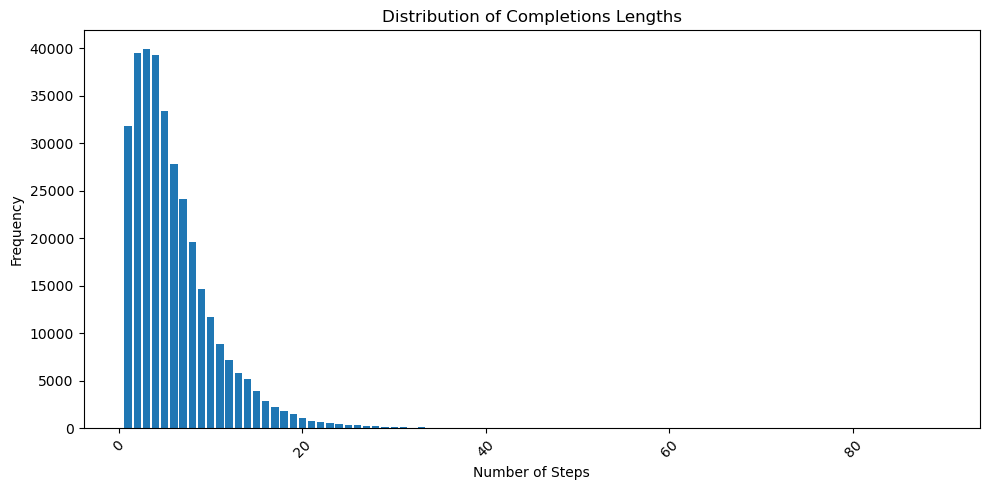

In [51]:
from collections import Counter
counter = Counter(lengths)

## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

100%|██████████| 9881/9881 [00:00<00:00, 3260220.09it/s]

{1: 997, 2: 1213, 3: 1275, 4: 1141, 5: 1044, 6: 810, 7: 705, 8: 619, 9: 455, 10: 302, 11: 208, 12: 220, 13: 174, 14: 125, 15: 92, 16: 85, 17: 62, 18: 28, 19: 45, 20: 47, 21: 21, 22: 25, 23: 40, 24: 29, 25: 12, 26: 7, 27: 14, 28: 24, 29: 9, 30: 4, 31: 7, 32: 7, 34: 8, 36: 6, 44: 7, 48: 7, 51: 7}


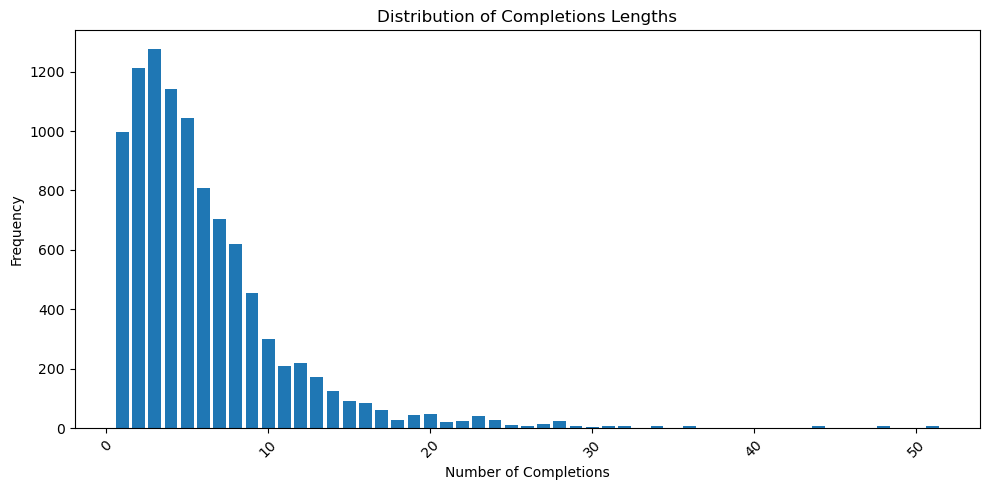

In [ ]:
from tqdm import tqdm
test_lengths = []
for i in tqdm(dataset['test']['completions']):
    test_lengths.append(len(i))
    
from collections import Counter
counter = Counter(test_lengths)

## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
from datasets import load_dataset

dataset = load_dataset("FrozenWolf/Gemini-AIME-Meta")


In [53]:
from tqdm import tqdm
lengths = []
for i in tqdm(dataset['train']['completions']):
    lengths.append(len(i))
    


100%|██████████| 933/933 [00:00<00:00, 3956810.55it/s]


{5: 4, 6: 19, 7: 35, 8: 55, 9: 66, 10: 70, 11: 70, 12: 72, 13: 82, 14: 95, 15: 58, 16: 55, 17: 44, 18: 45, 19: 26, 20: 30, 21: 17, 22: 14, 23: 19, 24: 15, 25: 12, 26: 11, 27: 6, 28: 2, 29: 2, 30: 1, 31: 3, 32: 1, 33: 1, 34: 1, 39: 1, 49: 1}


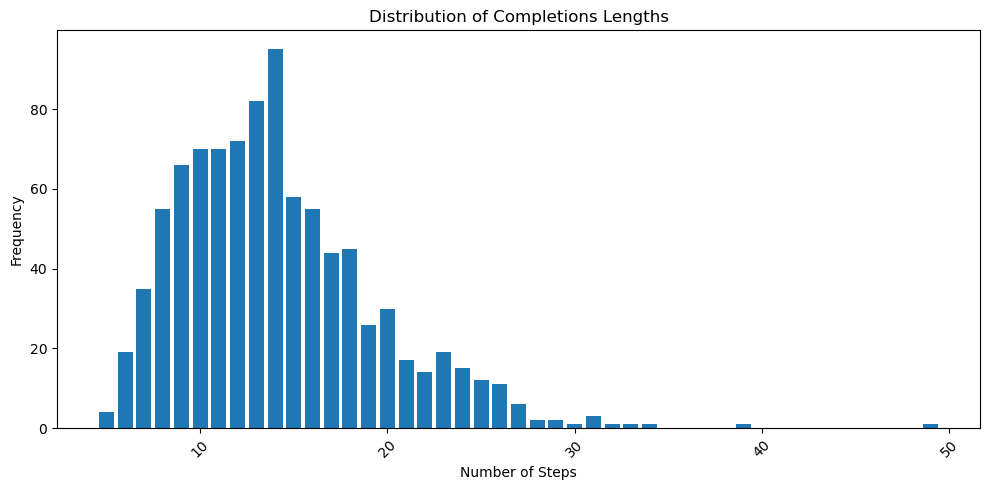

In [54]:
from collections import Counter
counter = Counter(lengths)

## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
!ls ~/Downloads | grep train_prm800k

train_prm800k.json


In [18]:
import pandas as pd
path = "/home/frozenwolf/Downloads/train_prm800k.json"
df = pd.read_json(path)
df

,id,sid,input,add,ground_truth,image_path,dataset,score,times,accuracy
0,1,1,The first four terms in an arithmetic sequence...,"To find the fifth term, I need to identify the...",\frac{123}{40},,prm800k,1,1,1
1,2,2,The first four terms in an arithmetic sequence...,The common difference is the same for any cons...,\frac{123}{40},,prm800k,1,1,1
2,3,3,The first four terms in an arithmetic sequence...,"For example, using the first and second terms,...",\frac{123}{40},,prm800k,1,1,1
3,4,4,The first four terms in an arithmetic sequence...,"Solving for $d$, I get $d = -2y$.",\frac{123}{40},,prm800k,1,1,1
4,5,5,The first four terms in an arithmetic sequence...,"Using another pair of terms, such as the secon...",\frac{123}{40},,prm800k,1,1,1
...,...,...,...,...,...,...,...,...,...,...
696993,696994,20,On the Cartesian plane in which each unit is o...,# Answer\n\n15,15,,prm800k,1,1,1
696994,696995,1,Suppose we are given seven points that are equ...,I notice that the problem is asking about the ...,5,,prm800k,1,1,1
696995,696996,2,Suppose we are given seven points that are equ...,"So, if I want to find the possible values of $...",5,,prm800k,1,1,1
696996,696997,3,Suppose we are given seven points that are equ...,I also notice that since the seven points are ...,5,,prm800k,1,1,1


In [27]:
lens = []
prev = 1
for sid in df['sid']:
    if sid==prev:
        prev+=1
    else:
        lens.append(prev-1)
        prev = 2
        
lens.append(prev-1)  # Append the last segment length

In [9]:
### groupby add and make it list
df = df.groupby(['input', 'ground_truth']).agg({
    'add': lambda x: list(x),
}).reset_index()

df

,input,ground_truth,add
0,"""Modulo $m$ graph paper"" consists of a grid of...",32,[I want to find the values of $x_0$ and $y_0$ ...
1,"""Modulo $m$ graph paper"" consists of a grid of...",10,"[I notice that both congruences are linear, so..."
2,$(81)^{\frac12}=3^m$. Find $m$.,2,"[To solve for $m$, I need to rewrite both side..."
3,$100_{10}$ in base $b$ has exactly $5$ digits....,3,[I know that $100_{10}$ means $1 \times 10^2 +...
4,"$12! = 47a001600$, for some digit $a$. What is...",a=9,"[This problem involves factorials, which are t..."
...,...,...,...
10812,Your math club has 20 members. In how many wa...,6840,"[To select a president, I have 20 options, sin..."
10813,Zachary paid for a $\$1$ burger with 32 coins ...,17,"[I need to find the number of nickels, let's c..."
10814,Zan has created this iterative rule for genera...,16,[I need to find out which numbers from 1 to 50...
10815,Zeno had to paint a $15^\prime \times 15^\prim...,8,"[This problem reminds me of Zeno's paradoxes, ..."


In [26]:
qn = df.iloc[0]['input']
df[df['input']==qn]

,id,sid,input,add,ground_truth,image_path,dataset,score,times,accuracy
0,1,1,The first four terms in an arithmetic sequence...,"To find the fifth term, I need to identify the...",\frac{123}{40},,prm800k,1,1,1
1,2,2,The first four terms in an arithmetic sequence...,The common difference is the same for any cons...,\frac{123}{40},,prm800k,1,1,1
2,3,3,The first four terms in an arithmetic sequence...,"For example, using the first and second terms,...",\frac{123}{40},,prm800k,1,1,1
3,4,4,The first four terms in an arithmetic sequence...,"Solving for $d$, I get $d = -2y$.",\frac{123}{40},,prm800k,1,1,1
4,5,5,The first four terms in an arithmetic sequence...,"Using another pair of terms, such as the secon...",\frac{123}{40},,prm800k,1,1,1
...,...,...,...,...,...,...,...,...,...,...
374818,374819,8,The first four terms in an arithmetic sequence...,"Combining the numerator, I get $(x-2y^2)/y$ as...",\frac{123}{40},,prm800k,1,1,1
374819,374820,9,The first four terms in an arithmetic sequence...,# Answer\n\n(x-2y^2)/y,\frac{123}{40},,prm800k,-1,1,0
650294,650295,1,The first four terms in an arithmetic sequence...,To find the fifth term in an arithmetic sequen...,\frac{123}{40},,prm800k,1,1,1
650295,650296,2,The first four terms in an arithmetic sequence...,I can subtract any two adjacent terms to find ...,\frac{123}{40},,prm800k,1,1,1


In [23]:
df[:50]

,id,sid,input,add,ground_truth,image_path,dataset,score,times,accuracy
0,1,1,The first four terms in an arithmetic sequence...,"To find the fifth term, I need to identify the...",\frac{123}{40},,prm800k,1,1,1
1,2,2,The first four terms in an arithmetic sequence...,The common difference is the same for any cons...,\frac{123}{40},,prm800k,1,1,1
2,3,3,The first four terms in an arithmetic sequence...,"For example, using the first and second terms,...",\frac{123}{40},,prm800k,1,1,1
3,4,4,The first four terms in an arithmetic sequence...,"Solving for $d$, I get $d = -2y$.",\frac{123}{40},,prm800k,1,1,1
4,5,5,The first four terms in an arithmetic sequence...,"Using another pair of terms, such as the secon...",\frac{123}{40},,prm800k,1,1,1
5,6,6,The first four terms in an arithmetic sequence...,"I have $xy = x-y + d$, so substituting $d = -2...",\frac{123}{40},,prm800k,1,1,1
6,7,7,The first four terms in an arithmetic sequence...,"Simplifying, I get $xy = x - 3y$.",\frac{123}{40},,prm800k,1,1,1
7,8,8,The first four terms in an arithmetic sequence...,"This seems like a reasonable equation, so I wi...",\frac{123}{40},,prm800k,0,1,0
8,9,9,The first four terms in an arithmetic sequence...,"Now, to find the fifth term, I need to add $d$...",\frac{123}{40},,prm800k,1,1,1
9,10,10,The first four terms in an arithmetic sequence...,"The fourth term is $x/y$, so the fifth term is...",\frac{123}{40},,prm800k,1,1,1


In [17]:
for i in df.iloc[0]['add']:
    print(i)
    print("=============================")

I want to find the values of $x_0$ and $y_0$ that satisfy the given congruence when either $x$ or $y$ is zero.
I can start by plugging in $y=0$ and see what happens.
Then I get $3x\equiv -1\pmod{35}$.
To solve for $x$, I need to find a multiplicative inverse of 3 modulo 35.
That is, I need to find a number $a$ such that $3a\equiv 1\pmod{35}$.
One way to do this is to use the extended Euclidean algorithm, which finds integers $a$ and $b$ such that $3a+35b=1$.
Alternatively, I can try to guess and check until I find a suitable $a$.
I notice that $3\cdot 12=36\equiv 1\pmod{35}$, so $a=12$ works.
Therefore, $x\equiv -1\cdot 12\equiv 23\pmod{35}$.
So the $x$-intercept is $(23,0)$ and $x_0=23$.
Now I need to find the $y$-intercept.
I can do this by plugging in $x=0$ and see what happens.
Then I get $0\equiv 4y-1\pmod{35}$.
To solve for $y$, I need to isolate it on one side of the congruence.
I can add 1 to both sides and get $1\equiv 4y\pmod{35}$.
Then I can divide both sides by 4, but I hav

In [38]:
from datasets import load_dataset, Dataset as HF_Dataset
meta_dataset2 = load_dataset("FrozenWolf/prm800k")['test']
meta_dataset1 = load_dataset("FrozenWolf/Gemini-AIME-Meta")['train']
df1 = meta_dataset2.to_pandas()[['prompt', 'answer', 'completions', 'correctness', 'labels']]
df2 = meta_dataset1.to_pandas()[['prompt', 'answer', 'completions', 'correctness', 'labels']]
df = pd.concat([df1, df2], ignore_index=True)
meta_dataset = HF_Dataset.from_pandas(df)

In [40]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B-Instruct")

In [44]:
from tqdm import tqdm
tqdm.pandas()

In [45]:
df['tokenized_length'] = df['completions'].progress_apply(lambda x: len(tokenizer(' '.join(x), return_tensors='pt')['input_ids'][0]))

  0%|          | 0/10814 [00:00<?, ?it/s]

100%|██████████| 10814/10814 [00:05<00:00, 1861.37it/s]


In [47]:
lengths = df['tokenized_length'].tolist()

{6: 4, 7: 3, 8: 2, 9: 3, 10: 1, 11: 1, 12: 3, 13: 8, 14: 7, 15: 10, 16: 11, 17: 13, 18: 15, 19: 26, 20: 21, 21: 25, 22: 27, 23: 20, 24: 26, 25: 33, 26: 32, 27: 44, 28: 34, 29: 47, 30: 41, 31: 35, 32: 36, 33: 34, 34: 24, 35: 30, 36: 28, 37: 27, 38: 32, 39: 29, 40: 33, 41: 26, 42: 19, 43: 27, 44: 25, 45: 31, 46: 24, 47: 25, 48: 24, 49: 30, 50: 23, 51: 37, 52: 19, 53: 28, 54: 38, 55: 31, 56: 23, 57: 25, 58: 29, 59: 25, 60: 28, 61: 33, 62: 42, 63: 36, 64: 32, 65: 30, 66: 37, 67: 46, 68: 32, 69: 51, 70: 34, 71: 38, 72: 39, 73: 50, 74: 38, 75: 41, 76: 53, 77: 37, 78: 40, 79: 38, 80: 37, 81: 30, 82: 45, 83: 22, 84: 34, 85: 35, 86: 27, 87: 46, 88: 46, 89: 34, 90: 37, 91: 45, 92: 45, 93: 30, 94: 38, 95: 35, 96: 36, 97: 45, 98: 43, 99: 26, 100: 32, 101: 41, 102: 37, 103: 33, 104: 37, 105: 36, 106: 36, 107: 34, 108: 27, 109: 34, 110: 31, 111: 42, 112: 25, 113: 32, 114: 30, 115: 31, 116: 40, 117: 37, 118: 43, 119: 36, 120: 30, 121: 34, 122: 34, 123: 37, 124: 37, 125: 33, 126: 46, 127: 32, 128: 25,

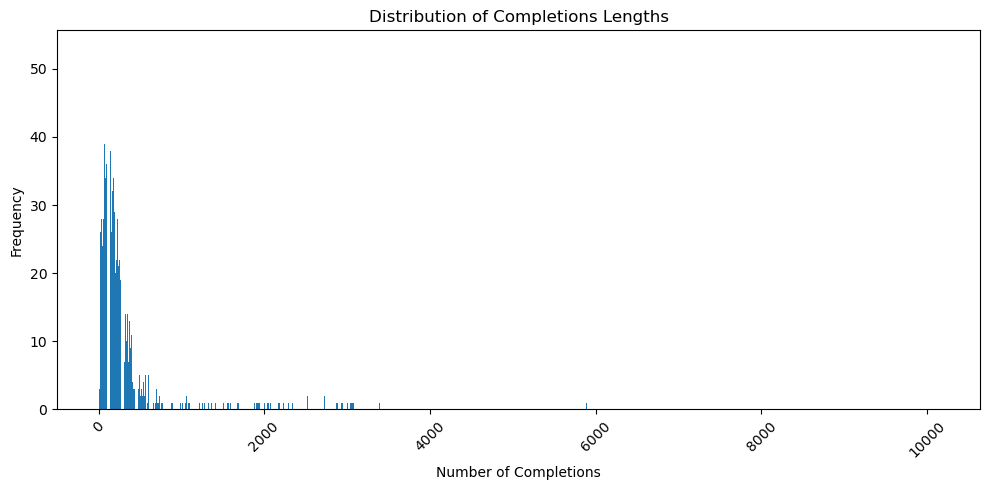

In [48]:
from collections import Counter
counter = Counter(lengths)

## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df = pd.concat([df1, df2], ignore_index=True)
meta_dataset = 

AttributeError: 'Dataset' object has no attribute 'concatenate'

In [29]:
from collections import Counter
counter = Counter(lens)

{1: 6780, 2: 9187, 3: 9526, 4: 10168, 5: 9535, 6: 8865, 7: 7348, 8: 6350, 9: 5312, 10: 4118, 11: 3154, 12: 3327, 13: 2305, 14: 2047, 15: 2618, 16: 1158, 17: 1218, 18: 743, 19: 713, 20: 751, 21: 385, 22: 547, 23: 245, 24: 219, 25: 157, 26: 125, 27: 135, 28: 90, 29: 53, 30: 52, 31: 43, 32: 112, 33: 30, 34: 15, 35: 16, 36: 13, 37: 13, 38: 11, 39: 1, 40: 5, 41: 1, 42: 2, 43: 2, 44: 3, 45: 1, 46: 2, 47: 1, 48: 1, 52: 1, 53: 2, 56: 1}


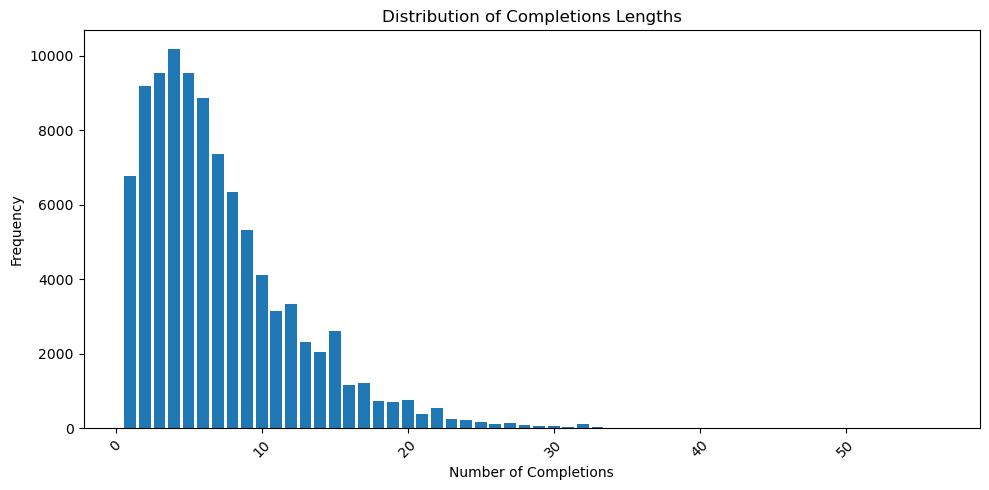

In [30]:
## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import json
import pandas as pd
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B-Instruct")
file = "data/meta.json"

df = pd.read_json(file)

In [65]:
df['step_len'] = df['input'].apply(lambda x: len(x.split("\n\n")))
df

,id,true_false,input,image_path,step_len
0,2,True,Question: The following diagram shows the bact...,dataset/MMMU/images/test/2.png,7
1,2,False,Question: The following diagram shows the bact...,dataset/MMMU/images/test/2.png,1
2,3,True,Question: A dam is to be constructed across a ...,dataset/MMMU/images/test/3.png,11
3,3,False,Question: A dam is to be constructed across a ...,dataset/MMMU/images/test/3.png,1
4,5,True,Question: The disk has a constant angular velo...,dataset/MMMU/images/test/5.png,7
...,...,...,...,...,...
495,487,True,Question: The structure identified by the arro...,dataset/MMMU/images/test/487.png,1
496,491,True,Question: Find the dimensions of the right cir...,dataset/MMMU/images/test/491.png,1
497,492,True,Question: What does cusp mean in the image?\nO...,dataset/MMMU/images/test/492.png,1
498,494,True,Question: The abnormal fiber that is seen with...,dataset/MMMU/images/test/494.png,1


In [71]:
### toke count
df['token_len'] = df['input'].apply(lambda x: len(tokenizer(x)['input_ids']))
df

,id,true_false,input,image_path,step_len,token_len
0,2,True,Question: The following diagram shows the bact...,dataset/MMMU/images/test/2.png,7,335
1,2,False,Question: The following diagram shows the bact...,dataset/MMMU/images/test/2.png,1,32
2,3,True,Question: A dam is to be constructed across a ...,dataset/MMMU/images/test/3.png,11,888
3,3,False,Question: A dam is to be constructed across a ...,dataset/MMMU/images/test/3.png,1,158
4,5,True,Question: The disk has a constant angular velo...,dataset/MMMU/images/test/5.png,7,554
...,...,...,...,...,...,...
495,487,True,Question: The structure identified by the arro...,dataset/MMMU/images/test/487.png,1,43
496,491,True,Question: Find the dimensions of the right cir...,dataset/MMMU/images/test/491.png,1,77
497,492,True,Question: What does cusp mean in the image?\nO...,dataset/MMMU/images/test/492.png,1,72
498,494,True,Question: The abnormal fiber that is seen with...,dataset/MMMU/images/test/494.png,1,51


In [77]:
df.sort_values(by='step_len', ascending=False, inplace=True)

In [78]:
df

,id,true_false,input,image_path,step_len,token_len
180,352,True,Question: Assume that in the course of solving...,dataset/MMMU/images/test/352.png,133,1139
204,397,True,Question: An excursion company is considering ...,dataset/MMMU/images/test/397.png,19,1401
182,355,True,Question: A commercial refrigerator with refri...,dataset/MMMU/images/test/355.png,16,902
254,499,True,Question: A solid cylindrical needle of diamet...,dataset/MMMU/images/test/499.png,15,901
90,166,True,Question: A hash table of length 10 uses open ...,dataset/MMMU/images/test/166.png,15,878
...,...,...,...,...,...,...
253,489,False,Question: What is the amount of interest? \nOp...,dataset/MMMU/images/test/489.png,1,40
5,5,False,Question: The disk has a constant angular velo...,dataset/MMMU/images/test/5.png,1,198
251,488,False,"Question: n $\triangle ABC$, $AB = 6$, $BC = 7...",dataset/MMMU/images/test/488.png,1,138
1,2,False,Question: The following diagram shows the bact...,dataset/MMMU/images/test/2.png,1,32


In [81]:
print(df['input'].iloc[2])

Question: A commercial refrigerator with refrigerant-134a as the working fluid is used to keep the refrigerated space at230°C by rejecting its waste heat to cooling water that enters the condenser at 18°C at a rate of 0.25 kg/s and leaves at 26°C. The refrigerant enters the condenser at 1.2 MPa and 65°C and leaves at 42°C. The inlet state of the compressor is 60 kPa and 234°C and the compressor is estimated to gain a net heat of 450 W from the surroundings. Determine the quality of the refrigerant at the evaporator inlet.
Options: (A) q=0.28 (B) q=0.38 (C) q=0.48

Let's analyze the question step by step:

### Step 1: Restate the question
The question asks to determine the quality of the refrigerant at the evaporator inlet, given the conditions and parameters of the refrigeration cycle involving refrigerant-134a.

### Step 2: Gather evidence from the image
The image is not directly relevant to this thermodynamics problem, so we'll focus on the provided textual data.

### Step 3: Identif

In [75]:
df['token_len'].max(), df['token_len'].mean()

(1401, 196.752)

In [76]:
df['step_len'].max(), df['step_len'].mean()

(133, 3.21)

{17: 1, 21: 1, 25: 1, 26: 3, 27: 1, 28: 4, 29: 2, 30: 5, 31: 4, 32: 3, 33: 5, 34: 6, 35: 5, 36: 6, 37: 1, 38: 7, 39: 6, 40: 6, 41: 2, 42: 4, 43: 8, 44: 3, 45: 4, 46: 6, 47: 6, 48: 3, 49: 3, 50: 7, 51: 7, 52: 2, 53: 6, 54: 2, 55: 7, 56: 4, 57: 4, 58: 4, 59: 3, 60: 5, 61: 5, 62: 3, 63: 7, 64: 3, 65: 1, 66: 2, 67: 3, 68: 4, 69: 3, 70: 5, 71: 1, 72: 2, 73: 3, 74: 4, 75: 2, 76: 5, 77: 5, 78: 2, 79: 2, 80: 3, 81: 2, 82: 2, 83: 1, 84: 2, 85: 1, 86: 2, 87: 2, 88: 2, 89: 3, 90: 1, 91: 4, 92: 4, 93: 4, 94: 1, 95: 2, 96: 1, 97: 4, 98: 2, 99: 2, 100: 2, 101: 3, 102: 1, 103: 1, 104: 1, 105: 4, 107: 4, 108: 4, 109: 3, 110: 2, 111: 3, 113: 1, 114: 2, 116: 4, 117: 1, 118: 3, 120: 4, 122: 4, 123: 1, 125: 1, 128: 1, 130: 4, 131: 1, 132: 2, 134: 1, 135: 1, 138: 2, 140: 1, 141: 1, 142: 1, 145: 1, 147: 2, 149: 2, 150: 1, 151: 1, 154: 1, 155: 1, 158: 1, 159: 1, 160: 1, 164: 1, 165: 2, 170: 2, 174: 1, 176: 1, 179: 1, 180: 1, 182: 1, 183: 2, 188: 2, 195: 1, 197: 1, 198: 1, 201: 1, 204: 2, 206: 1, 210: 1, 211:

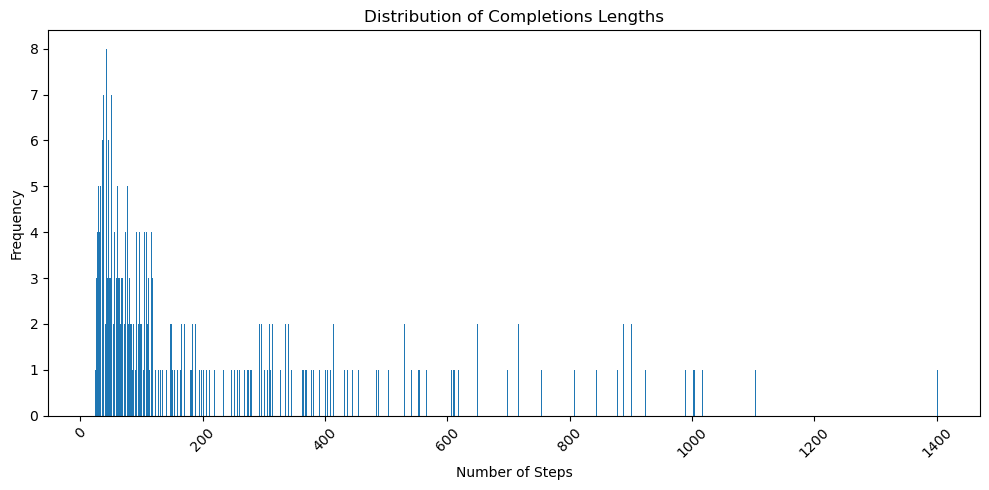

In [72]:
from collections import Counter
counter = Counter(df['token_len'].tolist())

## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

{1: 364, 2: 8, 7: 61, 8: 27, 9: 10, 10: 6, 11: 8, 12: 2, 13: 5, 14: 3, 15: 3, 16: 1, 19: 1, 133: 1}


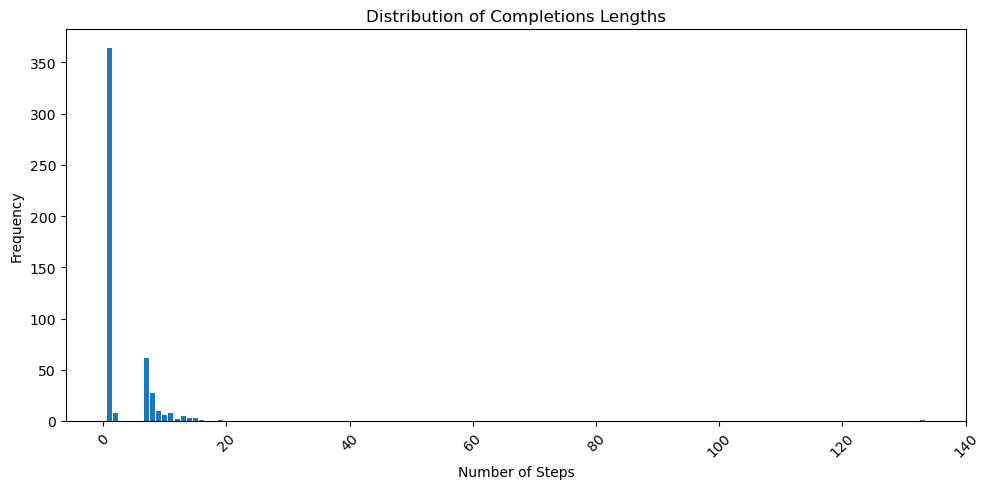

In [66]:
from collections import Counter
counter = Counter(df['step_len'].tolist())

## sort the counter by key
sorted_counter = dict(sorted(counter.items()))
print(sorted_counter)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(sorted_counter.keys(), sorted_counter.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Completions Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
print(df['input'].iloc[0])

Question: The following diagram shows the bacteriorhodopsin protein.This protein have quaternary structure.
Options: (A) True (B) False

Step 1: Restate the question.
   - The question is asking whether the bacteriorhodopsin protein has a quaternary structure based on the provided diagram.

Step 2: Gather evidence from the image.
   - The image shows a representation of the bacteriorhodopsin protein. However, the specific details of the protein's structure, such as its quaternary structure, are not visible in the image.

Step 3: Identify any background knowledge needed.
   - Bacteriorhodopsin is a protein found in the cell membrane of certain archaea.
   - It functions as a light-driven proton pump.
   - The protein structure of bacteriorhodopsin includes primary, secondary, and tertiary structures, but quaternary structure refers to the arrangement of multiple protein subunits.

Step 4: Reason with the current evidence.
   - The image does not provide enough detail to confirm or deny 